In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from IPython.core.display import display, HTML

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [3]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [4]:
# Load wrangled data saved in .csv files for both synapse and gromacs.
synapse_sessions = pd.read_csv('data/synapse/sessions.csv', index_col=0)
synapse_pilots = pd.read_csv('data/synapse/pilots.csv', index_col=0)
synapse_units = pd.read_csv('data/synapse/units.csv', index_col=0)

gromacs_sessions = pd.read_csv('data/sessions.csv', index_col=0)
gromacs_pilots = pd.read_csv('data/pilots.csv', index_col=0)
gromacs_units = pd.read_csv('data/units.csv', index_col=0)

In [5]:
print 'Synapse: Total number of successful runs: %s' % synapse_sessions.shape[0]
print 'Synapse: Total number of pilots: %s' % synapse_pilots.shape[0]
print 'Synapse: Total number of units: %s' % synapse_units.shape[0]

print 'GROMACS: Total number of successful runs: %s' % gromacs_sessions.shape[0]
print 'GROMACS: Total number of pilots: %s' % gromacs_pilots.shape[0]
print 'GROMACS: Total number of units: %s' % gromacs_units.shape[0]

Synapse: Total number of successful runs: 4
Synapse: Total number of pilots: 4
Synapse: Total number of units: 480
GROMACS: Total number of successful runs: 1
GROMACS: Total number of pilots: 1
GROMACS: Total number of units: 16384


# Synapse

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [6]:
synapse_wscaling = synapse_sessions[synapse_sessions.experiment == 'exp1'][
    ['nunit','TTC','U_AGENT_EXECUTING','P_LRMS_QUEUING']
        ].groupby(['nunit']).aggregate(
                {'TTC'  : ['mean','std'],
                 'U_AGENT_EXECUTING': ['mean','std'],
                 'P_LRMS_QUEUING': ['mean','std']})

synapse_wscaling.rename_axis({'U_AGENT_EXECUTING':'TTX'}, axis='columns', inplace=True)
synapse_wscaling.rename_axis({'P_LRMS_QUEUING':'TTQ'}, axis='columns', inplace=True)
synapse_wscaling

TTC             TTQ           TTX    
             mean std        mean std      mean std
nunit                                              
32      1335.7983 NaN    173.7546 NaN  900.1717 NaN
64      2798.3402 NaN   1626.5642 NaN  930.2295 NaN
128     2118.6245 NaN   1076.9728 NaN  935.3571 NaN
256    12054.3807 NaN  10853.7304 NaN  930.6828 NaN

(-0.5, 3.625)

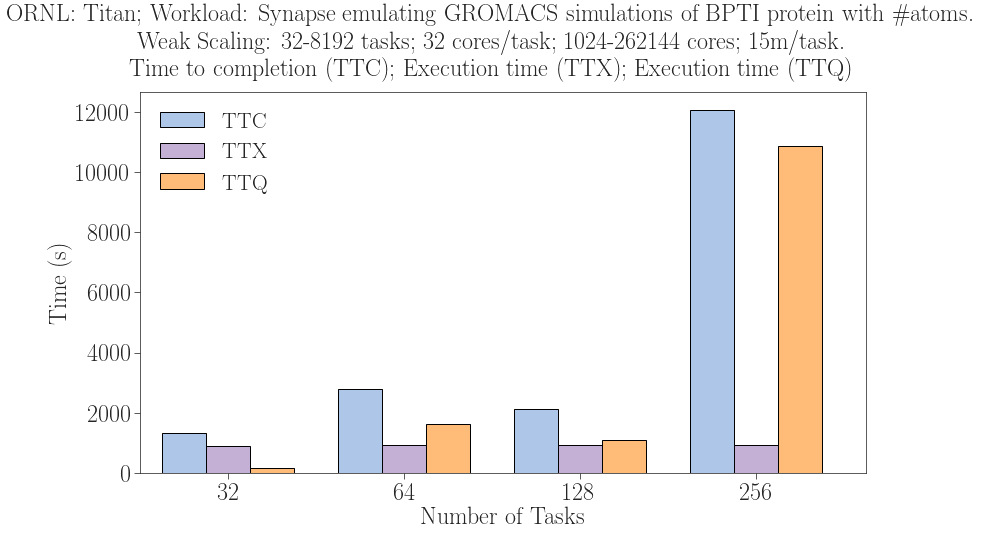

In [7]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL: Titan; Workload: Synapse emulating GROMACS simulations of BPTI protein with \#atoms.'
title_work = 'Weak Scaling: 32-8192 tasks; 32 cores/task; 1024-262144 cores; 15m/task.' 
title_desc = 'Time to completion (TTC); Execution time (TTX); Execution time (TTQ).'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
synapse_wscaling['TTC'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=0,
    label='TTC', kind='bar')

synapse_wscaling['TTX'].reset_index().plot(
    x='nunit', y='mean', yerr='std', 
    position=0.5, width=0.25, color=tableau20[9], ax=ax, rot=0,
    label='TTX', kind='bar')

synapse_wscaling['TTQ'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.25, color=tableau20[3], ax=ax, rot=0,
    label='TTQ', kind='bar')

ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

#plt.savefig('figures/weak_scaling.pdf', dpi=600, bbox_inches='tight')

# Gromacs

## Weak Scaling (exp1)

Definitions: 
* Weak scalability: how the solution time varies with the number of processors for a fixed problem size per processor
* Ideal Runtime: the time taken by the workload to run on the given resources without any overhead
* Walltime: the walltime asked for the pilot
* Max Walltime: the maximum walltime that can be asked for the given size of the pilot

|N runs| N tasks | N core/task | N generations | N pilot | N core/pilot | Ideal Runtime  | Walltime | Max Walltime | Resource |
|------|---------|-------------|---------------|---------|--------------|----------------|----------|--------------|----------|
| 2    | 32      | 32          | 1             | 1       | 1024         | 15m            | 1h       | 1h           | Titan    |
| 2    | 64      | 32          | 1             | 1       | 2048         | 15m            | 1h       | 6h           | Titan    |
| 2    | 128     | 32          | 1             | 1       | 4096         | 15m            | 1h       | 6h           | Titan    |
| 2    | 256     | 32          | 1             | 1       | 8192         | 15m            | 1h       | 12h          | Titan    |
| 2    | 512     | 32          | 1             | 1       | 16384        | 15m            | 1h       | 12h          | Titan    |
| 2    | 1024    | 32          | 1             | 1       | 32768        | 15m            | 1h       | 12h          | Titan    |
| 2    | 2048    | 32          | 1             | 1       | 65536        | 15m            | 1h       | 24h          | Titan    |
| 2    | 4096    | 32          | 1             | 1       | 131072       | 15m            | 1h       | 24h          | Titan    |
| 2    | 8192    | 32          | 1             | 1       | 262144       | 15m            | 1h       | 24h          | Titan    |

In [8]:
gromacs_wscaling = gromacs_sessions[gromacs_sessions.experiment == 'exp0'][
    ['nunit','TTC','U_AGENT_EXECUTING','P_LRMS_QUEUING']
        ].groupby(['nunit']).aggregate(
                {'TTC'  : ['mean','std'],
                 'U_AGENT_EXECUTING': ['mean','std'],
                 'P_LRMS_QUEUING': ['mean','std']})

gromacs_wscaling.rename_axis({'U_AGENT_EXECUTING':'TTX'}, axis='columns', inplace=True)
gromacs_wscaling.rename_axis({'P_LRMS_QUEUING':'TTQ'}, axis='columns', inplace=True)
gromacs_wscaling

TTC            TTQ           TTX    
            mean std       mean std      mean std
nunit                                            
16384  4296.2154 NaN  2243.1948 NaN  1929.718 NaN

(-0.5, 0.625)

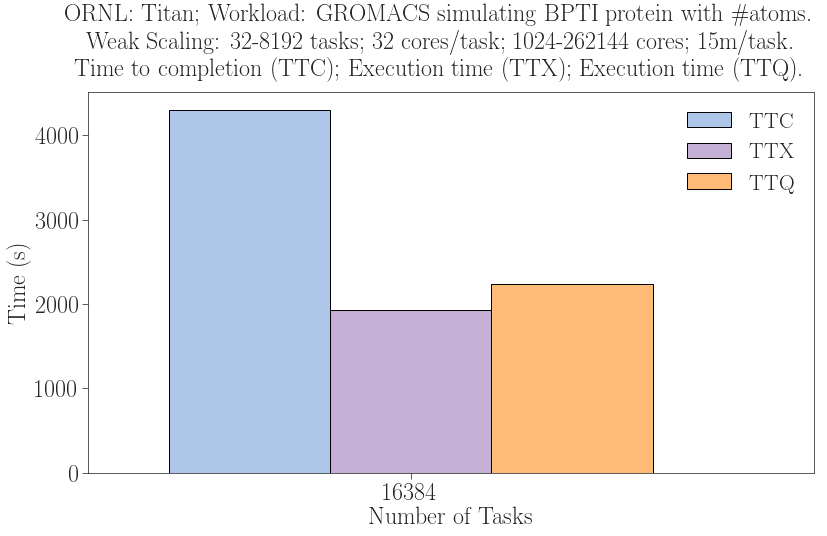

In [9]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_subplot(111)  

title_head = 'ORNL: Titan; Workload: GROMACS simulating BPTI protein with \#atoms.'
title_work = 'Weak Scaling: 32-8192 tasks; 32 cores/task; 1024-262144 cores; 15m/task.' 
title_desc = 'Time to completion (TTC); Execution time (TTX); Execution time (TTQ).'
title = '%s\n%s\n%s' % (title_head, title_work, title_desc)
fig.suptitle(title, y=1.05)

# Plot means and std bars
gromacs_wscaling['TTC'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=0,
    label='TTC', kind='bar')

gromacs_wscaling['TTX'].reset_index().plot(
    x='nunit', y='mean', yerr='std', 
    position=0.5, width=0.25, color=tableau20[9], ax=ax, rot=0,
    label='TTX', kind='bar')

gromacs_wscaling['TTQ'].reset_index().plot(
    x='nunit', y='mean', yerr='std',
    position=-0.5, width=0.25, color=tableau20[3], ax=ax, rot=0,
    label='TTQ', kind='bar')

ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')
ax.set_xlim(-0.5)

#plt.savefig('figures/weak_scaling.pdf', dpi=600, bbox_inches='tight')